In [1]:
%reload_ext autoreload
#!pip install -r requirements.txt

In [2]:
%autoreload
from architectures.RTSGAN import *
from utils import *
from trainers import *
import numpy as np
np.random.seed(42)

trainset = TimeGANDatasetSinus(num=1200, seq_len=100, alpha=0.7, noise=0)
testset = TimeGANDatasetSinus(num=300, seq_len=100, alpha=0.7, noise=0)
print(len(testset))
print(testset[0][0].size())


300
torch.Size([100, 3])


In [ ]:
%autoreload
import neptune.new as neptune
import torch

run = neptune.init_run(
    project="kohmann/RTSGAN",
    name="rtsgan",
    tags=[],
    description="test",
    source_files=["architectures/RTSGAN.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_rtsgan.pt",
    "n_epochs": 3000,
    "l_rate": 0.001,
    "l_rate_ae": 0.001,
    "batch_size": 128*2,
    "num_layers": 2,
    "hidden_dim": 40,
    "spectralnorm": True,
    "optimizer": "Adam", # RMSprop
    "dis_thresh": 0.15,
    "d_steps": 5,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "testset_size": len(testset),
    "device": device,
    "optimizer_ae": "Adam",
}
params["Z_dim"] = (params["num_layers"] +1) * params["hidden_dim"]
run["parameters"] = params

model = RTSGAN(params)
rtsgan_trainer(model, trainset, params, neptune_logger=run, continue_training=False)

# Generate random synthetic data
gen_z = rtsgan_generator(model, params)

log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

run.stop()

https://app.neptune.ai/kohmann/RTSGAN/e/RTSGAN-43
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Embedding Network Training


Epoch: 249, Loss: 0.0145: 100%|██████████| 250/250 [00:30<00:00,  8.30it/s]



Start GAN Training


Epoch: 224, G: -40.1873, D: 33.3001:   7%|▋         | 224/3000 [00:33<06:21,  7.28it/s]

In [5]:
gen_z = rtsgan_generator(model, params)


Generating Data...Done


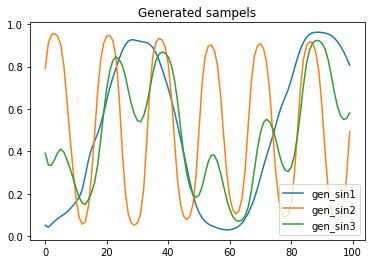

In [6]:
sample = 10
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

/tmp/ipykernel_178/1743573133.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]


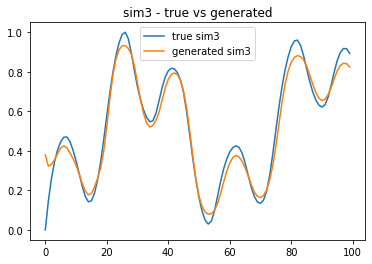

In [7]:
sample = 4
real_combo = create_sin3(gen_z[sample][:,0], gen_z[sample][:,1], alpha=0.7, noise=0)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]
gen_combo = gen_z[sample][:,2]
plt.plot(real_comb_scaled, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()

In [9]:
%autoreload
from metrics import compare_sin3_generation
compare_sin3_generation(gen_z, 0.7, 0)

MSE Error: 0.00529
Run RTSGAN-35 received stop signal. Exiting
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/RTSGAN/e/RTSGAN-35


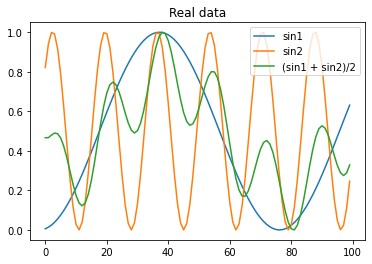

In [15]:
sample = trainset.__getitem__(9)
plt.plot(sample[0][:,0], label="sin1")
plt.plot(sample[0][:,1], label="sin2")
plt.plot(sample[0][:,2], label="(sin1 + sin2)/2")
plt.title("Real data")
plt.legend()